In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Voroni cells from the street network

Here we use the TIGER/Lines data to for a graph of the street network
- The library code automates loading the data, and can also intelligently discard edges which look "wrong" (have no name, or a name which suggests that they are a railroad).
- We form a Voroni diagram by using the mid point of each edge in the graph.
- However, we then compute the "segments" of the graph.  A segment is a path where each interior node in the path has degree two.  I.e. something which corresponds to the notion of a street between intersections.
- We merge the voroni cells for each segment.

This works pretty well.  Some problems are:
- A small number of cases where we have e.g. parallel roads leading to thin, disconnected, cells
- Somewhat dependence on the edges in the original graph-- our placement of points is not uniform.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import geopandas as gpd
import numpy as np
import tilemapbase
import shapely.geometry
import descartes

import impute.chicago
import impute.tiger_lines
import impute.voroni

import open_cp.geometry
open_cp.geometry.configure_gdal()
import open_cp.logger
open_cp.logger.log_to_true_stdout("impute")
import pyproj
proj = pyproj.Proj({"init":"epsg:2790"})

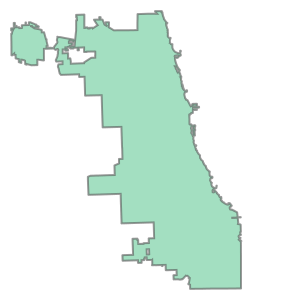

In [3]:
#datadir = os.path.join("..", "..", "..", "..", "Data")
datadir = os.path.join("/media", "disk", "Data")
g = gpd.GeoDataFrame.from_file(os.path.join(datadir, "Chicago_Areas.geojson"))
g.crs = {'init': 'epsg:4326'}
g = g.to_crs({"init":"epsg:2790"}).geometry
chicago = g.unary_union.buffer(15)
chicago

## Make the graph

The library supports loading both the "edges" and "roads" TIGER/Lines data.
- We then form the "reduced" graph.
- Use the "edges" data as input, uses both datasets to get a list of possible names for each edge
- If all the names are bad (empty, ALLEY, or railroad) then ignore.

In [4]:
#tigerdir = os.path.join("..", "..", "..", "..", "Data", "TIGER Data")
tigerdir = os.path.join("/media", "disk", "TIGER Data")
tl = impute.tiger_lines.TigerLines(os.path.join(tigerdir, "tl_2016_17031_roads"),
                        os.path.join(tigerdir, "tl_2016_17031_edges"), proj)

In [5]:
graph, reduced_edge_lookup = tl.make_reduced_graph()

## Start by using all segments

- Consider each "segment" of the graph (a segment is a path of edges where each internal vertex has degree 2).
- Form the voroni diagram: points are the mid-points of each edge, and then we merge cells in each segment

In [7]:
segments = list(open_cp.network.segment_graph(graph))

In [8]:
voroni = impute.voroni.VoroniGraphSegments(graph, segments)

In [9]:
polygons = list(voroni.all_polygons_clipped(chicago))

In [10]:
nonempty_polygons = [p for p in polygons if not p.is_empty]

In [11]:
proj(*np.asarray(chicago.centroid), inverse=True)

(-87.68602747974174, 41.837293419939634)

In [12]:
def project_polygon(p):
    if p.geometryType() == "Polygon":
        poly = []
        for x, y in zip(*proj(*np.asarray(p.exterior).T, inverse=True)):
            poly.append(tilemapbase.project(x, y))
        return shapely.geometry.Polygon(poly)
    else:
        return shapely.geometry.MultiPolygon([project_polygon(pp) for pp in p])

In [22]:
def make_lines():
    lines = []
    for i, seg in enumerate(segments):
        line = [graph.vertices[key] for key in open_cp.network.edge_segment_to_vertices(graph, seg)]
        linex, liney = proj(*np.asarray(line).T, inverse=True)
        line = [tilemapbase.project(x,y) for x,y in zip(linex, liney)]
        lines.append(line)
    return lines

def draw(lon, lat, xsize=0.0001, voroni_points = False):
    ex = tilemapbase.Extent.from_centre_lonlat(lon, lat, xsize)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

    fig, ax = plt.subplots(figsize=(8,8))
    plotter.plot(ax, alpha=0.6)

    lc = matplotlib.collections.LineCollection(make_lines())
    ax.add_collection(lc)

    pp = [descartes.PolygonPatch(project_polygon(p)) for p in nonempty_polygons]
    pp = matplotlib.collections.PatchCollection(pp, color="red", alpha=0.3)
    ax.add_collection(pp)
    
    if voroni_points:
        points = [tilemapbase.project(x, y) for x, y in zip(*proj(*voroni._voroni.points.T, inverse=True))]
        ax.scatter(*np.asarray(points).T, marker="x", color="black", linewidth=0.5)

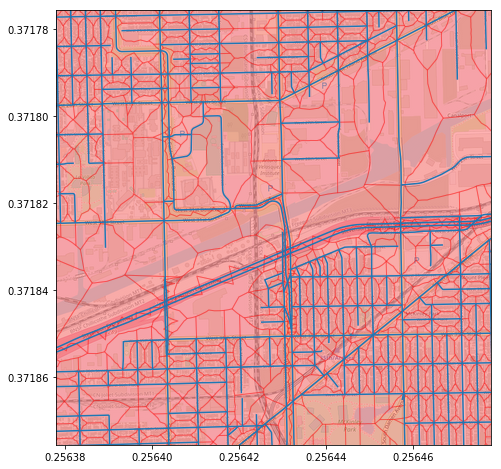

In [13]:
draw(-87.686, 41.837)

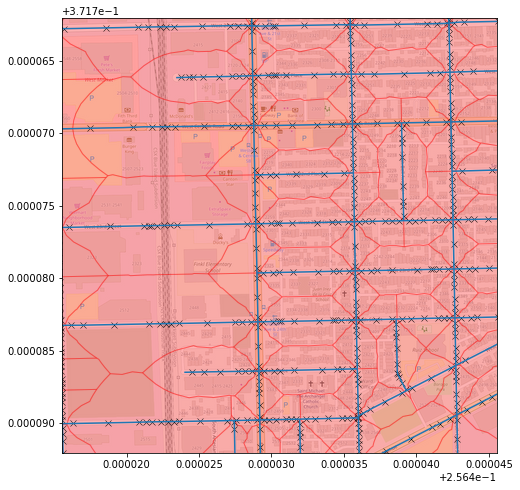

In [14]:
draw(-87.685, 41.85, 0.00003, True)

## Thoughts

As we use the mid-point of each edge to form the initial "voroni points", if the edges are not uniformly long, then we can get a bias in the voroni cells produced.  In practise, the effect above looks pretty good.

In [15]:
frame = gpd.GeoDataFrame({"cell" : list(range(len(nonempty_polygons)))})
frame.geometry = nonempty_polygons
frame.crs = {"init":"epsg:2790"}
frame.head()

,cell,geometry
0,0,(POLYGON ((363114.2635396473 567874.4402381747...
1,1,"POLYGON ((356278.1355538853 591892.2742105717,..."
2,2,"(POLYGON ((360261.3909332905 576332.516920548,..."
3,3,"POLYGON ((356278.3030009117 591889.689488613, ..."
4,4,"POLYGON ((354402.2628017128 594482.0135284517,..."


In [16]:
frame.to_file("chicago_voroni_1")

## Problems

From QGIS, we found the following odd situation, concerning polygons 16753 and 40138.
- Look in the middle, bottom, of the plot
- What's going on is that there is a dual carriageway here, and the TIGER/Lines data contains 2 parallel edges
- The road on the left is slightly bent, so the graph has a number of edges, leading to a number of midpoints inputted into the Voroni diagram
- The road on the right is straight, so one edge in the graph, so only one point.

So this is really an extreme form of the problem we discussed above: we don't place points in any way _uniformly_ along the edges.

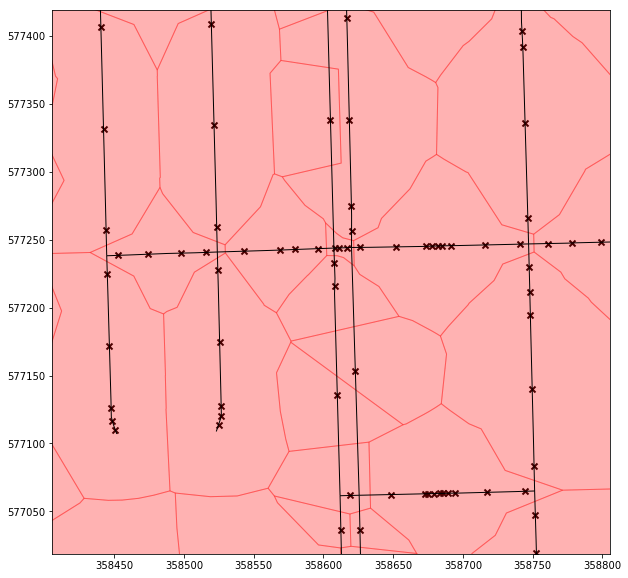

In [39]:
fig, ax = plt.subplots(figsize=(10,10))

lines = []
for i, seg in enumerate(segments):
    line = [graph.vertices[key] for key in open_cp.network.edge_segment_to_vertices(graph, seg)]
    lines.append(line)
lc = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(lc)

ax.scatter(*voroni.voroni.points.T, marker="x", color="black", linewidth=2)

pp = [descartes.PolygonPatch(p) for p in nonempty_polygons]
pp = matplotlib.collections.PatchCollection(pp, color="red", alpha=0.3)
ax.add_collection(pp)

x, y = np.mean(np.asarray(nonempty_polygons[16753][0].exterior),axis=0)
d = 200
ax.set(xlim=[x-d,x+d], ylim=[y-d,y+d])
None